In [1]:
from datasets.dtu import DTUDataset
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

torch.backends.cudnn.benchmark = True # this increases inference speed a little

# Load pretrained model

In [43]:
from models.mvsnet import CascadeMVSNet
from utils import load_ckpt
from inplace_abn import ABN
model = CascadeMVSNet(n_depths=[8,32,48],
                      interval_ratios=[1.0,2.0,4.0],
                      num_groups=1,
                      use_attention=False,
                      use_atv=False,
                      norm_act=ABN).cuda()
load_ckpt(model, 'ckpts/exp2/_ckpt_epoch_10.ckpt')
# load_ckpt(model, 'ckpts/exp2_g8/_ckpt_epoch_48.ckpt')
# load_ckpt(model, 'ckpts/exp_g8_atv/_ckpt_epoch_5.ckpt')
model.eval();

In [44]:
dataset = DTUDataset('/home/ubuntu/data/DTU/mvs_training/dtu/', 'test', n_views=5, depth_interval=2.65,
                     img_wh=(768, 576))

In [45]:
def decode_batch(batch):
    imgs = batch['imgs']
    proj_mats = batch['proj_mats']
    depths = batch['depths']
    masks = batch['masks']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

imgs, proj_mats, depths, masks, init_depth_min, depth_interval = decode_batch(dataset[0])
unpreprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                           std=[1/0.229, 1/0.224, 1/0.225])

# Visualize an example depth

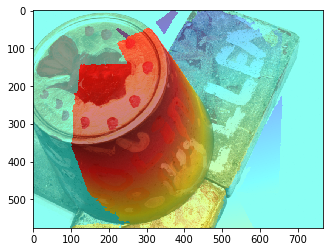

In [46]:
from utils import *
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(depths['level_0']*masks['level_0']).permute(1,2,0), alpha=0.5)

# Do inference on this sample

In [47]:
t = time.time()
with torch.no_grad():
    results = model(imgs.unsqueeze(0).cuda(), proj_mats.unsqueeze(0).cuda(), init_depth_min, depth_interval)
    torch.cuda.synchronize()
print('inference time', time.time()-t)

inference time 0.23209857940673828


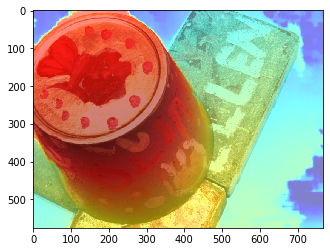

In [48]:
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.5)

562.1762084960938 tensor(8.5687, device='cuda:0')


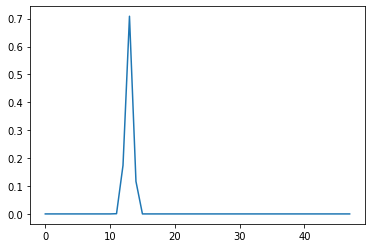

In [49]:
plt.plot(results['prob_volume_2'][0, :, 105, 70].cpu().numpy())
print(results['depth_2'][0, 105, 70].item(), results['depth_std_2'][0, 105, 70]*1.5)

16


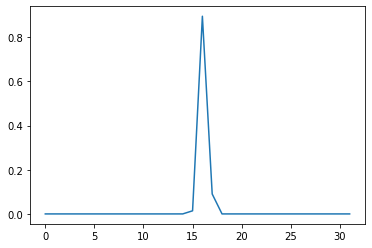

In [50]:
plt.plot(results['prob_volume_1'][0, :, 210, 140].cpu().numpy())
print(np.argmax(results['prob_volume_1'][0, :, 210, 140].cpu().numpy()))

In [51]:
results['depth_values_1'][0, :, 210, 140]

tensor([476.0095, 481.3094, 486.6095, 491.9095, 497.2095, 502.5095, 507.8094,
        513.1094, 518.4095, 523.7095, 529.0095, 534.3094, 539.6094, 544.9095,
        550.2095, 555.5095, 560.8094, 566.1095, 571.4095, 576.7095, 582.0095,
        587.3094, 592.6095, 597.9095, 603.2095, 608.5095, 613.8094, 619.1095,
        624.4095, 629.7095, 635.0095, 640.3094], device='cuda:0')

In [52]:
results['depth_interval_0'][0, 0, 210, 140]

TypeError: 'float' object is not subscriptable

In [31]:
results['depth_2'][0, 105, 70].item()#-4*results['depth_std_1'][0, 210, 140]*2*1.5/16

562.1762084960938

In [32]:
depths['level_0'][420, 280].item(), results['depth_0'][0, 420, 280].item()

(561.905517578125, 562.1217651367188)

In [33]:
results['depth_interval_0'][0, 0, 420, 280]

tensor(0.3063, device='cuda:0')

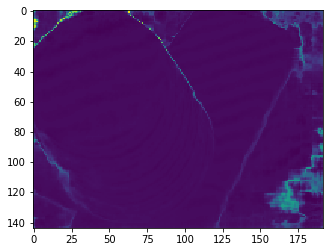

In [34]:
plt.imshow(results['depth_std_2'][0].cpu().numpy())

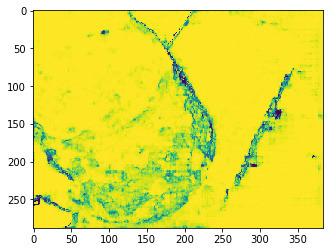

In [35]:
plt.imshow(results['confidence_1'][0].cpu().numpy())

In [36]:
depth_exp = results['depth_0'][0].cpu().numpy()
depth_std = cv2.resize(results['depth_std_1'][0].cpu().numpy(), None, fx=2, fy=2)
depth_interval = results['depth_interval_0'][0][0].cpu().numpy()
# mask = (depths['level_0'].numpy() < depth_exp+1.5*depth_std) & (depths['level_0'].numpy()-depth_exp>-1.5*depth_std)
mask = (depths['level_0'].numpy() < depth_exp+4*depth_interval) & (depths['level_0'].numpy()-depth_exp>-4*depth_interval)

In [53]:
plt.hist(16*results['depth_interval_1'][0][0].cpu().numpy().flatten(), bins=np.linspace(0,20,50), density=True);

TypeError: 'float' object is not subscriptable

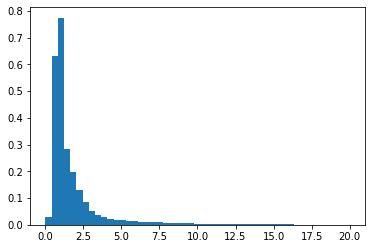

In [38]:
plt.hist(8*results['depth_interval_0'][0][0].cpu().numpy().flatten(), bins=np.linspace(0,20,50), density=True);

0.27024106626157407

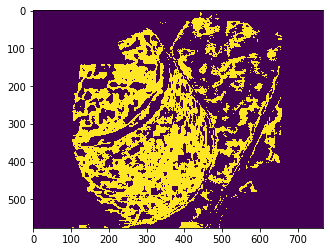

In [39]:
plt.imshow(mask)
mask.mean()

(array([2.5200e+02, 1.1077e+04, 4.1510e+03, 1.8900e+02, 6.5000e+01,
        3.0000e+01, 1.3000e+01, 8.0000e+00, 7.0000e+00, 5.5000e+01]),
 array([ 1.698678 ,  3.5288103,  5.3589425,  7.1890745,  9.019207 ,
        10.849339 , 12.679471 , 14.5096035, 16.339735 , 18.169868 ,
        20.       ], dtype=float32),
 <a list of 10 Patch objects>)

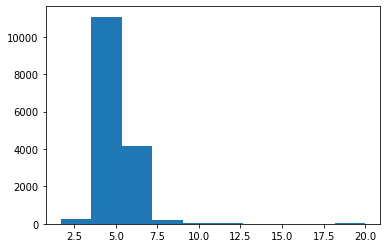

In [40]:
a = results['depth_std_2'][0].cpu().numpy()[masks['level_2']]
a[a>20] = 20
plt.hist(a)

(array([17959., 25534.,  9655.,  5100.,  2328.,   967.,   508.,   264.,
          158.,  1042.]),
 array([0.08552849, 0.27697563, 0.4684228 , 0.65986997, 0.8513171 ,
        1.0427642 , 1.2342114 , 1.4256586 , 1.6171057 , 1.8085529 ,
        2.        ], dtype=float32),
 <a list of 10 Patch objects>)

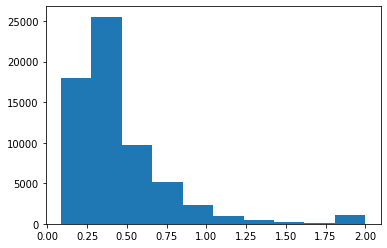

In [41]:
a = results['depth_std_1'][0].cpu().numpy()[masks['level_1']]
a[a>2] = 2
plt.hist(a)

# Reference: show pixels whose absolute depth error is less than 2mm

acc_2mm : 0.9336512684822083


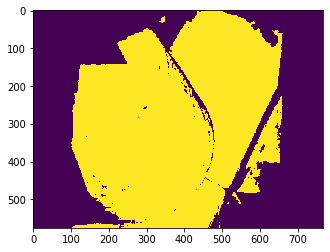

In [54]:
err2 = torch.abs(depths['level_0']-results['depth_0'].cpu())[0]<2
plt.imshow(err2);
print('acc_2mm :', ((err2.float()*masks['level_0']).sum()/masks['level_0'].sum()).item())